In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/nlp/

/content/drive/MyDrive/Colab Notebooks/nlp


In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset

import os
import zipfile
import json


In [ ]:
import sklearn as mat
mat.__version__

'1.6.1'

In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [ ]:
my_pal = ['1f77b4', 'ff8c1a', '2ca02c', 'd62728', '9467bd', 'c5b300', 'e377c2', '17becf']
my_pal = [f"#{c}" for c in my_pal]

sns.reset_defaults() # useful when adjusting style a lot
plt.rcParams['font.family']=['sans-serif']
sns.set_theme(context="paper", style="ticks",
              # palette="Set2",
              palette=my_pal,
              rc={
              "pdf.fonttype": 42,  # embed font in output
              "svg.fonttype": "none",  # embed font in output
              "figure.facecolor": "white",
              "figure.dpi": 150,
              "axes.facecolor": "None",
              "axes.spines.left": True,
              "axes.spines.bottom": True,
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
train = pd.read_csv('subtask2/train/swa.csv')
test = pd.read_csv('subtask2/dev/swa.csv')
# fix this for this subtask
train.head()
train['stratify_key'] = train[['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']].apply(
    lambda row: '_'.join(row.astype(str)), axis=1
)

train, val = train_test_split(
    train,
    test_size=0.2
)

train.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other,stratify_key
3875,swa_1e08a561fc1d7881fffb4822639b357f,kenya iuzw mtu apew share yake ama waturudishi...,0,0,0,0,0,0_0_0_0_0
1768,swa_b436d75df7d5cc4847f2c973740e49d0,bana rt mamzee especially hawa hapa twitter rt...,0,1,0,0,0,0_0_0_1_0
3250,swa_71b7ef26027e30d7f0e3025b5afb45ff,uliwaibia nani hao majembe la kutombwa pussy m...,0,0,0,0,0,0_0_0_0_0
6574,swa_fb121178c35ba35b1fafc735704824fa,Woi Museveni will kill us hio kamba hata ya ba...,0,1,0,0,1,0_0_0_1_1
2815,swa_1352a5d0c27ff8f79314abf4597a5046,mt hulipwa na supremacist mweupe kila wakati h...,0,0,0,0,0,0_0_0_0_0


In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item
class PolarizationTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze(0) for key in encoding.keys()}
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base
# Create train and Test dataset for multilabel

train_dataset = PolarizationDataset(train['text'].tolist(), train[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
test_dataset = PolarizationDataset(test['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
# dev_dataset = PolarizationTestDataset(test['text'].tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('Davlan/afro-xlmr-base', num_labels=5, problem_type="multi_label_classification",ignore_mismatched_sizes=True) # 5 labels

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
label_cols = ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']
tokenizer = AutoTokenizer.from_pretrained('Davlan/afro-xlmr-base')
train_dataset = PolarizationDataset(
    train['text'].tolist(),
    train[label_cols].values.tolist(),
    tokenizer
)

val_dataset = PolarizationDataset(
    val['text'].tolist(),
    val[label_cols].values.tolist(),
    tokenizer
)

test_dataset = PolarizationTestDataset(
    test['text'].tolist(),
    tokenizer
)


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## new


In [ ]:
def compute_class_weights(labels_array):
    """Compute weights for each class based on frequency"""
    pos_counts = labels_array.sum(axis=0)
    neg_counts = len(labels_array) - pos_counts
    weights = neg_counts / (pos_counts + 1e-5)  # Avoid division by zero
    return torch.FloatTensor(weights)

class_weights = compute_class_weights(train[label_cols].values)
print(f"\nClass weights: {class_weights.numpy()}")

# Custom Trainer with weighted loss
class WeightedBCETrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted BCE loss
        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
        else:
            loss_fct = torch.nn.BCEWithLogitsLoss()

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Improved metrics with optimal threshold search
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions)).numpy()
    labels = p.label_ids

    # Try multiple thresholds and pick the best
    best_f1 = 0
    best_threshold = 0.5

    for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
        preds = (probs > threshold).astype(int)
        f1 = f1_score(labels, preds, average='macro', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Use best threshold
    preds = (probs > best_threshold).astype(int)

    # Per-class F1 scores
    per_class_f1 = f1_score(labels, preds, average=None, zero_division=0)

    metrics = {
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'f1_micro': f1_score(labels, preds, average='micro', zero_division=0),
        'f1_weighted': f1_score(labels, preds, average='weighted', zero_division=0),
        'best_threshold': best_threshold
    }

    # Add per-class metrics
    label_names = ['gender_sexual', 'political', 'religious', 'racial_ethnic', 'other']
    for i, name in enumerate(label_names):
        metrics[f'f1_{name}'] = per_class_f1[i]

    return metrics

# Optimized training arguments
training_args = TrainingArguments(
    output_dir="/content/outputs/",

    # Training schedule
    num_train_epochs=5,
    learning_rate=3e-5,  # Slightly higher for faster convergence
    lr_scheduler_type="linear",
    warmup_ratio=0.1,

    # Batch sizes
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    # Regularization
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    save_total_limit=3,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Performance
    fp16=True,
    dataloader_num_workers=2,

    # Other
    seed=42,
    report_to="none"
)


Class weights: [48.052628  36.28      27.100502   1.8313924 11.263158 ]


In [ ]:
# Initialize trainer with class weights
trainer = WeightedBCETrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

# Train
print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

trainer.train()

log_history = trainer.state.log_history
# Evaluate on validation set
print("\n" + "="*50)
print("Validation Results:")
print("="*50)
eval_results = trainer.evaluate()
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")

# # Generate predictions on test set (no labels available)
# print("\n" + "="*50)
# print("Generating predictions on test set...")
# print("="*50)
# test_predictions = trainer.predict(test_dataset)
# test_probs = torch.sigmoid(torch.from_numpy(test_predictions.predictions)).numpy()
# test_preds = (test_probs > 0.5).astype(int)

# # Create submission dataframe
# submission = test.copy()
# submission[label_cols] = test_preds

# print(f"\nPredictions shape: {test_preds.shape}")
# print(f"Sample predictions:\n{submission[['text'] + label_cols].head()}")


Starting training...



Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,Best Threshold,F1 Gender Sexual,F1 Political,F1 Religious,F1 Racial Ethnic,F1 Other
1,1.129700,1.110519,0.402941,0.435224,0.578810,0.500000,0.304348,0.126582,0.721649,0.701561,0.160567
2,0.916700,0.945983,0.373187,0.510523,0.621603,0.600000,0.175182,0.168224,0.530612,0.778857,0.213058
3,0.713800,1.008205,0.426522,0.588462,0.643935,0.700000,0.271429,0.280702,0.575758,0.790698,0.214022
4,0.650800,1.030040,0.426039,0.577591,0.642065,0.700000,0.248276,0.220000,0.632479,0.782427,0.247012
5,0.517700,1.107556,0.448373,0.603275,0.655949,0.700000,0.244275,0.288136,0.649123,0.792291,0.268041



Validation Results:


eval_loss: 1.1076
eval_f1_macro: 0.4484
eval_f1_micro: 0.6033
eval_f1_weighted: 0.6559
eval_best_threshold: 0.7000
eval_f1_gender_sexual: 0.2443
eval_f1_political: 0.2881
eval_f1_religious: 0.6491
eval_f1_racial_ethnic: 0.7923
eval_f1_other: 0.2680
eval_runtime: 1.4412
eval_samples_per_second: 970.7460
eval_steps_per_second: 30.5310


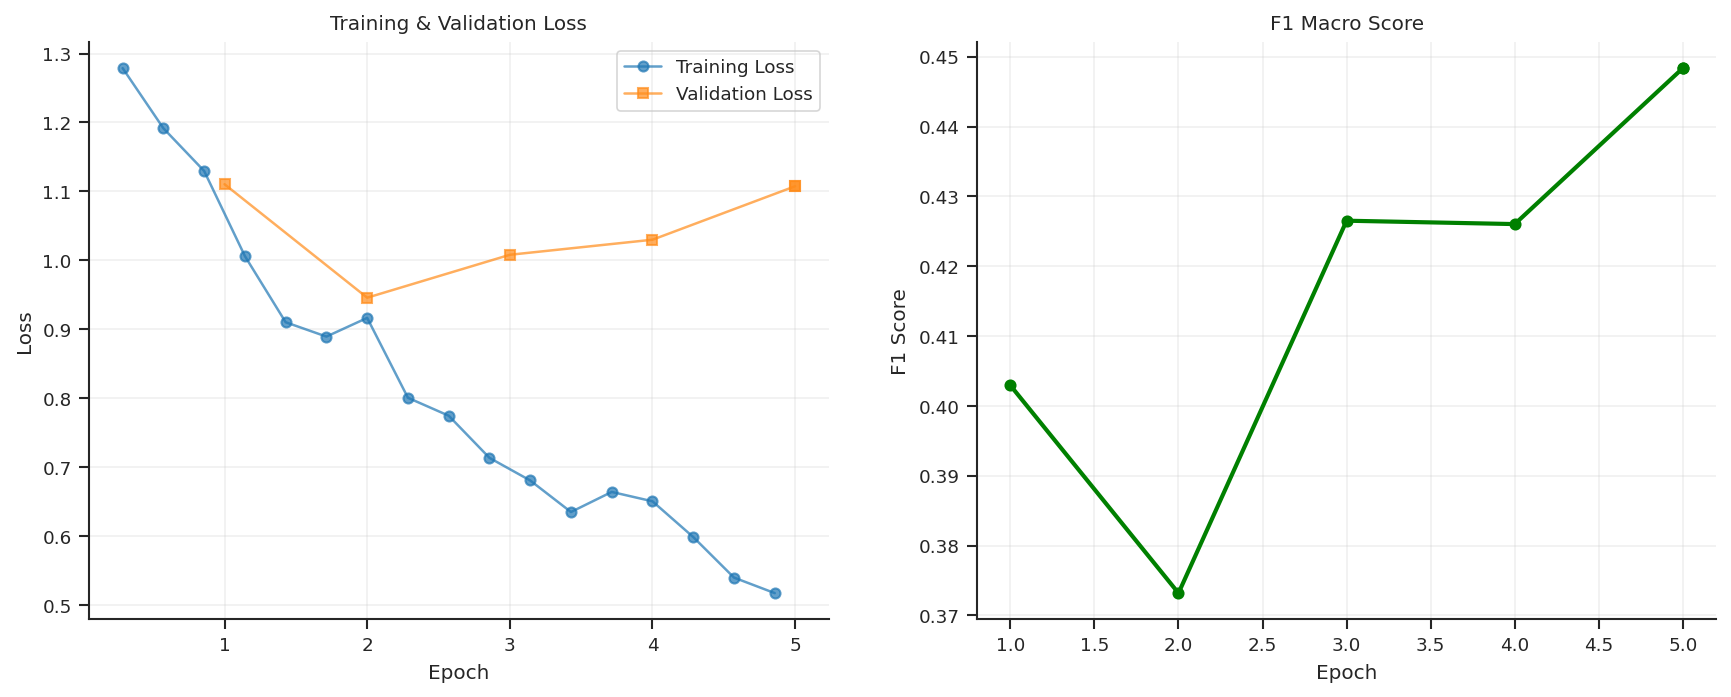

In [ ]:
# Convert to DataFrame for easier plotting
logs_df = pd.DataFrame(log_history)
# print(logs_df)

# Prepare data
train_logs = logs_df[logs_df['loss'].notna()]
eval_logs = logs_df[logs_df['eval_loss'].notna()]

# Create subplot mosaic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Both losses
axes[0].plot(train_logs['epoch'], train_logs['loss'], label='Training Loss', marker='o', alpha=0.7)
axes[0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss', marker='s', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: F1 Score
axes[1].plot(eval_logs['epoch'], eval_logs['eval_f1_macro'], marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Macro Score')
axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
plt.savefig('subtask2_swa_afroxlmr_complexsingle',dpi=200,format='pdf' )
plt.show()

## From semeval



In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"/content/outputs/",
    num_train_epochs=10,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)
# trainer = CombinedMetricTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics_multilabel,  # ← Using multi-label metrics
#     data_collator=DataCollatorWithPadding(tokenizer),
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
#     f1_weight=0.7,  # 70% focus on F1
#     loss_weight=0.3  # 30% focus on loss
# )

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.145000,0.211448,0.349743
2,0.099700,0.254075,0.427579
3,0.063800,0.305956,0.388176
4,0.049900,0.314245,0.382823


KeyboardInterrupt: 

In [ ]:
import os
import zipfile
import numpy as np

predictions = trainer.predict(test_dataset)

# For multi-label classification, you need to apply sigmoid and threshold
# Assuming your model outputs logits for each label
predicted_probs = torch.sigmoid(torch.tensor(predictions.predictions))

# Apply threshold (0.5) to get binary predictions
predicted_labels = (predicted_probs > 0.5).int().numpy()

# If you have 5 labels in order: political, racial/ethnic, religious, gender/sexual, other
# Create a dataframe with all columns
results_df = pd.DataFrame({
    'id': test['id'],
    'political': predicted_labels[:, 0],
    'racial/ethnic': predicted_labels[:, 1],
    'religious': predicted_labels[:, 2],
    'gender/sexual': predicted_labels[:, 3],
    'other': predicted_labels[:, 4]
})

# Create the folder if it doesn't exist
os.makedirs('subtask_2', exist_ok=True)

# Save to CSV in the folder
csv_path = 'subtask_2/pred_eng.csv'
results_df.to_csv(csv_path, index=False)

print(f"Saved predictions to {csv_path}")
print(results_df.head())

# Compress the folder
zip_filename = 'subtask_2_swa_single_afroxlmr_complex.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the folder and add all files
    for root, dirs, files in os.walk('subtask_2'):
        for file in files:
            file_path = os.path.join(root, file)
            # Add file to zip with relative path
            arcname = os.path.join(os.path.basename(root), file)
            zipf.write(file_path, arcname)

print(f"Created compressed file: {zip_filename}")

Saved predictions to subtask_2/pred_eng.csv
                                     id  political  racial/ethnic  religious  \
0  swa_a5748df181277341143f7da4175add4a          0              0          0   
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d          0              0          0   
2  swa_3718757514005767302b7220b08e409d          0              0          0   
3  swa_9fa3337a35cce723d60c06056d422330          0              0          0   
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0          0              0          0   

   gender/sexual  other  
0              1      0  
1              1      0  
2              1      0  
3              1      0  
4              1      0  
Created compressed file: subtask_2_swa_single_afroxlmr_complex.zip


In [ ]:
#prediction on test
trainer.save_model('sub2_eng')

## look for loading model

# new large


In [ ]:
import os
import zipfile
import json
# ============================================
# Configuration
# ============================================
CONFIG = {
    'english': {
        'model_name': 'cardiffnlp/twitter-roberta-base-hate',
        'train_file': 'subtask2/train/eng.csv',
        'test_file': 'subtask2/dev/eng.csv',
        'output_name': 'eng'
    },
    'swahili': {
        'model_name': 'Davlan/afro-xlmr-base',
        'train_file': 'subtask2/train/swa.csv',
        'test_file': 'subtask2/dev/swa.csv',
        'output_name': 'swa'
    }
}
# cardiffnlp/twitter-roberta-base-hate-multiclass-latest
# metabloit/swahBERT
# microsoft/deberta-v3-base
# Davlan/afro-xlmr-base
# cardiffnlp/twitter-roberta-base-sentiment-latest
# FacebookAI/xlm-roberta-base

# cardiffnlp/twitter-roberta-base-hate
# cardiffnlp/bertweet-base-hate

# Tadesse/AfroXLMR-Social


# castorini/afriteva_base


# test for english
# cardiffnlp/twitter-roberta-base-2022-154m
LABEL_COLUMNS = ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']

# Select language
LANGUAGE = 'english'
config = CONFIG[LANGUAGE]


In [ ]:
# @title Multiclass ensemble prediction



# ============================================
# Dataset Classes
# ============================================
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

class MultiLabelTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

# ============================================
# Custom Trainer with Combined Metric
# ============================================
class CombinedMetricTrainer(Trainer):
    """Custom Trainer that optimizes for both F1 score and loss reduction"""
    def __init__(self, *args, f1_weight=0.7, loss_weight=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.f1_weight = f1_weight
        self.loss_weight = loss_weight
        self.train_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Track training loss"""
        outputs = model(**inputs)
        loss = outputs.loss
        self.train_losses.append(loss.item())
        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Add combined score metric"""
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)

        f1 = metrics.get(f'{metric_key_prefix}_f1_macro', 0)
        loss = metrics.get(f'{metric_key_prefix}_loss', 0)

        normalized_loss = min(loss / 2.0, 1.0)
        combined_score = (self.f1_weight * f1) - (self.loss_weight * normalized_loss)
        metrics[f'{metric_key_prefix}_combined_score'] = combined_score

        if self.train_losses:
            avg_train_loss = np.mean(self.train_losses[-100:])
            metrics[f'{metric_key_prefix}_train_loss_recent'] = avg_train_loss

        return metrics

# ============================================
# Enhanced Monitoring Callback
# ============================================
class EnhancedMonitoringCallback(TrainerCallback):
    """Callback to monitor and log F1, train loss, and eval loss"""
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_combined = -float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'combined_score': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0) if state.log_history else 0)
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)
            combined_score = metrics.get('eval_combined_score', 0)

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)
            self.history['combined_score'].append(combined_score)

            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
            if combined_score > self.best_combined:
                self.best_combined = combined_score

            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")
            print(f"  Combined Score:  {combined_score:.4f} (Best: {self.best_combined:.4f})")

            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            if combined_score == self.best_combined:
                print(f"  ✓ NEW BEST COMBINED SCORE!")
            print(f"{'='*70}\n")

# ============================================
# Early Stopping with Combined Metric
# ============================================
class CombinedEarlyStoppingCallback(TrainerCallback):
    """Early stopping based on combined F1 and loss metric"""
    def __init__(self, patience=5):
        self.patience = patience
        self.best_combined_score = -float('inf')
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            combined_score = metrics.get('eval_combined_score', -float('inf'))

            if combined_score > self.best_combined_score:
                self.best_combined_score = combined_score
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                print(f"\n⚠ Early stopping triggered after {self.patience} epochs without improvement")
                print(f"Best combined score: {self.best_combined_score:.4f}")
                control.should_training_stop = True

# ============================================
# Compute Metrics for Multi-Label
# ============================================
def compute_metrics_multilabel(p):
    """Compute macro F1 for multi-label classification"""
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro', zero_division=0)}

# ============================================
# Create Stratification Key for Multi-Label
# ============================================
def create_stratify_key(df, label_columns):
    """Create a stratification key for multi-label data"""
    return df[label_columns].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# ============================================
# K-Fold Cross-Validation with Enhanced Training
# ============================================
def train_kfold_cv(train_df, model_name, label_columns, n_splits=5, seed=42):
    """Train model using K-Fold Cross-Validation for multi-label classification"""

    # Create stratification key
    train_df['stratify_key'] = create_stratify_key(train_df, label_columns)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Task: Multi-Label Classification ({len(label_columns)} labels)")
    print(f"Optimization: Maximize F1 + Minimize Loss")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify_key'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = MultiLabelDataset(
            train_fold['text'].tolist(),
            train_fold[label_columns].values.tolist(),
            tokenizer
        )
        val_dataset = MultiLabelDataset(
            val_fold['text'].tolist(),
            val_fold[label_columns].values.tolist(),
            tokenizer
        )

        # Load config and set dropout parameters
        model_config = AutoConfig.from_pretrained(model_name)
        model_config.hidden_dropout_prob = 0.2
        model_config.attention_probs_dropout_prob = 0.2
        model_config.classifier_dropout = 0.3
        model_config.num_labels = len(label_columns)
        model_config.problem_type = "multi_label_classification"

        # Initialize model with dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True
        )

        # Enhanced training arguments
        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,
            learning_rate=2e-5,
            lr_scheduler_type="linear",
            warmup_ratio=0.15,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            gradient_accumulation_steps=2,
            weight_decay=0.01,
            max_grad_norm=1.0,
            label_smoothing_factor=0.1,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=25,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="combined_score",
            greater_is_better=True,
            fp16=True,
            dataloader_num_workers=2,
            disable_tqdm=False,
            report_to="none"
        )

        # Initialize callbacks
        monitoring_callback = EnhancedMonitoringCallback()
        early_stopping_callback = CombinedEarlyStoppingCallback(patience=5)

        # Initialize custom trainer
        trainer = CombinedMetricTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics_multilabel,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback, early_stopping_callback],
            f1_weight=0.7,
            loss_weight=0.3
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()

        # Final evaluation
        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']
        fold_combined = eval_results['eval_combined_score']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"  Combined Score: {fold_combined:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_combined,
            'fold': fold + 1,
            'history': monitoring_callback.history
        })

    # Print summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"{'='*70}\n")

    # Plot results
    plot_all_folds(fold_models, config['model_name'], LANGUAGE)

    return fold_models, fold_metrics

# ============================================
# Plotting Function
# ============================================
def plot_all_folds(fold_models, model_name, language):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt

    cfg = CONFIG[language]
    # Extract short model name from full path
    short_model_name = cfg['model_name'].split('/')[-1]

    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    # Left plot: Losses for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title(f'Training & Validation Loss - {short_model_name}', fontsize=12, fontweight='bold')
    axes['losses'].legend(fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    # Right plot: F1 scores for all folds
    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title(f'F1 Macro Score - {short_model_name}', fontsize=12, fontweight='bold')
    axes['f1'].legend(fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    # Save with model name in filename
    plot_filename = f'multilabel_{cfg["output_name"]}_{short_model_name}.pdf'
    plt.savefig(plot_filename, dpi=200, format='pdf')
    print(f"\n✓ Plot saved to: {plot_filename}")
    plt.show()

# ============================================
# Ensemble Prediction for Multi-Label
# ============================================
def ensemble_predict_multilabel(fold_models, test_dataset, method='weighted', threshold=0.5):
    """Make ensemble predictions for multi-label classification"""
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions))
        all_predictions.append(probs.numpy())

        if method == 'weighted':
            weights.append(fold_model['score'])
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])
        else:
            weights.append(1.0)

    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    # Weighted average of probabilities
    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    # Apply threshold
    final_predictions = (weighted_probs > threshold).astype(int)

    return final_predictions

# ============================================
# Save Models in Compressed Format
# ============================================
def save_fold_models(fold_models, fold_metrics, language):
    """Save all fold models and metrics in a single compressed file"""
    cfg = CONFIG[language]

    short_model_name = cfg['model_name'].split('/')[-1]

    temp_dir = f"/content/temp_models_{cfg['output_name']}"
    os.makedirs(temp_dir, exist_ok=True)

    # Save best model
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]

    best_model_dir = os.path.join(temp_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)
    best_fold_model['model'].save_pretrained(best_model_dir)
    best_fold_model['tokenizer'].save_pretrained(best_model_dir)

    print(f"\n✓ Best model prepared (Fold {best_fold_model['fold']})")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")

    # Save all fold models
    for fold_model in fold_models:
        fold_dir = os.path.join(temp_dir, f"fold_{fold_model['fold']}")
        os.makedirs(fold_dir, exist_ok=True)
        fold_model['model'].save_pretrained(fold_dir)
        fold_model['tokenizer'].save_pretrained(fold_dir)
        print(f"✓ Prepared Fold {fold_model['fold']}")

    # Save metrics
    metrics_path = os.path.join(temp_dir, "fold_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    # Save model info
    model_info = {
        'language': language,
        'model_name': cfg['model_name'],
        'short_model_name': short_model_name,
        'best_fold': best_fold_model['fold'],
        'best_f1': best_fold_model['score'],
        'best_combined_score': best_fold_model['combined_score'],
        'n_folds': len(fold_models),
        'label_columns': LABEL_COLUMNS
    }
    info_path = os.path.join(temp_dir, "model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    zip_filename = f"multilabel_{cfg['output_name']}_{short_model_name}.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    print(f"\nCompressing all models...")
    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    import shutil
    shutil.rmtree(temp_dir)

    print(f"\n{'='*70}")
    print(f"✓ All models saved to compressed file:")
    print(f"  {final_path}")
    print(f"  Model: {short_model_name}")
    print(f"  Language: {language}")
    print(f"{'='*70}\n")

# ============================================
# LOAD SAVED MODEL FOR PREDICTION
# ============================================
def load_saved_model(language='english', model_name=None):
    """
    Load the best saved model from compressed file

    Args:
        language: 'english' or 'swahili'
        model_name: Optional specific model name (e.g., 'xlm-roberta-base').
                   If None, uses the model_name from CONFIG

    Returns:
        model, tokenizer, model_info
    """
    cfg = CONFIG[language]

    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/multilabel_{cfg['output_name']}_{short_model_name}.zip"

    print(f"Loading model from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    # Load best model
    best_model_dir = os.path.join(temp_extract_dir, "best_model")
    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

    print(f"✓ Model loaded successfully!")
    print(f"  Model: {model_info['short_model_name']}")
    print(f"  Best Fold: {model_info['best_fold']}")
    print(f"  F1 Score: {model_info['best_f1']:.4f}")

    return model, tokenizer, model_info

# ============================================
# LOAD ALL FOLD MODELS FOR ENSEMBLE
# ============================================
def load_all_fold_models(language='english', model_name=None):
    """
    Load all saved fold models from compressed file for ensemble prediction

    Args:
        language: 'english' or 'swahili'
        model_name: Optional specific model name (e.g., 'xlm-roberta-base').
                   If None, uses the model_name from CONFIG

    Returns:
        fold_models: List of model dictionaries
    """
    cfg = CONFIG[language]

    # Use provided model_name or extract from config
    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/multilabel_{cfg['output_name']}_{short_model_name}.zip"

    print(f"\nLoading all fold models from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info and metrics
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    with open(os.path.join(temp_extract_dir, "fold_metrics.json"), 'r') as f:
        fold_metrics = json.load(f)

    n_folds = model_info['n_folds']
    fold_models = []

    print(f"Loading {n_folds} fold models for {language} ({short_model_name})...")

    for fold_num in range(1, n_folds + 1):
        fold_dir = os.path.join(temp_extract_dir, f"fold_{fold_num}")

        print(f"  Loading Fold {fold_num}...")

        model = AutoModelForSequenceClassification.from_pretrained(fold_dir)
        tokenizer = AutoTokenizer.from_pretrained(fold_dir)

        fold_metric = fold_metrics[fold_num - 1]

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': fold_metric['f1'],
            'eval_loss': fold_metric['eval_loss'],
            'combined_score': fold_metric['combined_score']
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {fold_metric['f1']:.4f}, Loss: {fold_metric['eval_loss']:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models

# ============================================
# PREDICT WITH SAVED MODEL
# ============================================
def predict_with_saved_model(test_csv_path, language='english', model_name=None,
                             output_csv='predictions.csv', threshold=0.5):
    """
    Make predictions using saved best model

    Args:
        test_csv_path: Path to test CSV file
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        output_csv: Output CSV filename
        threshold: Prediction threshold for multi-label
    """
    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    # Create test dataset
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Create trainer for prediction
    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Make predictions
    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    probs = torch.sigmoid(torch.tensor(predictions.predictions))
    predicted_labels = (probs > threshold).int().numpy()

    # Save results
    label_cols = model_info['label_columns']
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(label_cols):
        results_df[col] = predicted_labels[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df[label_cols].sum())

    return results_df

# ============================================
# ENSEMBLE PREDICT WITH SAVED MODELS
# ============================================
def ensemble_predict_with_saved_models(test_csv_path, language='english', model_name=None,
                                       method='weighted_combined',
                                       output_csv='ensemble_predictions.csv',
                                       threshold=0.5):
    """
    Make ensemble predictions using all saved fold models

    Args:
        test_csv_path: Path to test CSV file
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        method: 'average', 'weighted', or 'weighted_combined'
        output_csv: Output CSV filename
        threshold: Prediction threshold for multi-label
    """
    # Load all fold models
    fold_models = load_all_fold_models(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    # Create test dataset
    tokenizer = fold_models[0]['tokenizer']
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Make ensemble predictions
    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict_multilabel(fold_models, test_dataset, method=method, threshold=threshold)

    # Save results
    results_df = pd.DataFrame({
        'id': test['id'],
        'gender/sexual': final_predictions[:, 0],
        'political': final_predictions[:, 1],
        'religious': final_predictions[:, 2],
        'racial/ethnic': final_predictions[:, 3],
        'other': final_predictions[:, 4]
    })

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    return results_df

# ============================================
# CONTINUE TRAINING SAVED MODEL
# ============================================
def continue_training(train_csv_path, language='english', model_name=None, additional_epochs=5):
    """
    Continue training a saved model

    Args:
        train_csv_path: Path to training CSV
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        additional_epochs: Number of additional epochs to train
    """
    from sklearn.model_selection import train_test_split

    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load training data
    train = pd.read_csv(train_csv_path)
    print(f"Train size: {len(train)}")

    # Create stratification key
    train['stratify_key'] = create_stratify_key(train, LABEL_COLUMNS)

    # Split into train/val
    train_split, val_split = train_test_split(
        train,
        test_size=0.2,
        stratify=train['stratify_key'],
        random_state=42
    )

    # Create datasets
    train_dataset = MultiLabelDataset(
        train_split['text'].tolist(),
        train_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )
    val_dataset = MultiLabelDataset(
        val_split['text'].tolist(),
        val_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/outputs/continued_training",
        num_train_epochs=additional_epochs,
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_ratio=0.1,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_multilabel,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Continue training
    print(f"\nContinuing training for {additional_epochs} epochs...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\n✓ Final F1 Score: {eval_results['eval_f1_macro']:.4f}")

    # Save updated model
    cfg = CONFIG[language]
    short_model_name = model_info['short_model_name']
    updated_model_dir = f"/content/temp_updated_model"
    os.makedirs(updated_model_dir, exist_ok=True)
    trainer.save_model(updated_model_dir)
    tokenizer.save_pretrained(updated_model_dir)

    # Compress updated model
    zip_filename = f"multilabel_{cfg['output_name']}_{short_model_name}_updated.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(updated_model_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, updated_model_dir)
                zipf.write(file_path, arcname)

    print(f"✓ Updated model saved to: {final_path}")

    return trainer

# ============================================
# Main Training Pipeline
# ============================================
def main():
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"\nLabel distribution:")
    print(train[LABEL_COLUMNS].sum())

    # Train with K-Fold CV
    fold_models, fold_metrics = train_kfold_cv(
        train,
        config['model_name'],
        LABEL_COLUMNS,
        n_splits=5,
        seed=42
    )



    # Create test dataset
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Ensemble predictions
    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict_multilabel(
        fold_models,
        test_dataset,
        method='weighted_combined',
        threshold=0.5
    )

    # Save predictions
    results_df = pd.DataFrame({
        'id': test['id'],
        'gender/sexual': final_predictions[:, 0],
        'political': final_predictions[:, 1],
        'religious': final_predictions[:, 2],
        'racial/ethnic': final_predictions[:, 3],
        'other': final_predictions[:, 4]
    })

    os.makedirs('subtask_2', exist_ok=True)
    csv_path = f'subtask_2/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    # Compress
    zip_filename = f'subtask_2_{config["output_name"]}_ensemble.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_2'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")
    # Save models
    save_fold_models(fold_models, fold_metrics, LANGUAGE)



In [ ]:
# @title simplified multiclass ensemble

class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

class MultiLabelTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) if pd.notna(self.texts[idx]) else ""
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item

class CombinedMetricTrainer(Trainer):
    """Custom Trainer that optimizes for both F1 score and loss reduction"""
    def __init__(self, *args, f1_weight=0.7, loss_weight=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.f1_weight = f1_weight
        self.loss_weight = loss_weight
        self.train_losses = []

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Track training loss"""
        outputs = model(**inputs)
        loss = outputs.loss
        self.train_losses.append(loss.item())
        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Add combined score metric"""
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)

        f1 = metrics.get(f'{metric_key_prefix}_f1_macro', 0)
        loss = metrics.get(f'{metric_key_prefix}_loss', 0)

        normalized_loss = min(loss / 2.0, 1.0)
        combined_score = (self.f1_weight * f1) - (self.loss_weight * normalized_loss)
        metrics[f'{metric_key_prefix}_combined_score'] = combined_score

        if self.train_losses:
            avg_train_loss = np.mean(self.train_losses[-100:])
            metrics[f'{metric_key_prefix}_train_loss_recent'] = avg_train_loss

        return metrics

# ============================================
# Enhanced Monitoring Callback
# ============================================
class EnhancedMonitoringCallback(TrainerCallback):
    """Callback to monitor and log F1, train loss, and eval loss"""
    def __init__(self):
        self.best_f1 = -float('inf')
        self.best_eval_loss = float('inf')
        self.best_train_loss = float('inf')
        self.best_combined = -float('inf')
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'combined_score': []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            if logs['loss'] < self.best_train_loss:
                self.best_train_loss = logs['loss']

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            epoch = state.epoch
            train_loss = metrics.get('train_loss', state.log_history[-1].get('loss', 0) if state.log_history else 0)
            eval_loss = metrics.get('eval_loss', 0)
            eval_f1 = metrics.get('eval_f1_macro', 0)
            combined_score = metrics.get('eval_combined_score', 0)

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['eval_loss'].append(eval_loss)
            self.history['eval_f1'].append(eval_f1)
            self.history['combined_score'].append(combined_score)

            if eval_f1 > self.best_f1:
                self.best_f1 = eval_f1
            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
            if combined_score > self.best_combined:
                self.best_combined = combined_score

            print(f"\n{'='*70}")
            print(f"Epoch {epoch:.1f} Metrics:")
            print(f"{'='*70}")
            print(f"  F1 Score:        {eval_f1:.4f} (Best: {self.best_f1:.4f})")
            print(f"  Eval Loss:       {eval_loss:.4f} (Best: {self.best_eval_loss:.4f})")
            print(f"  Train Loss:      {train_loss:.4f} (Best: {self.best_train_loss:.4f})")
            print(f"  Combined Score:  {combined_score:.4f} (Best: {self.best_combined:.4f})")

            if eval_f1 == self.best_f1:
                print(f"  ✓ NEW BEST F1!")
            if eval_loss == self.best_eval_loss:
                print(f"  ✓ NEW BEST EVAL LOSS!")
            if combined_score == self.best_combined:
                print(f"  ✓ NEW BEST COMBINED SCORE!")
            print(f"{'='*70}\n")

# ============================================
# Early Stopping with Combined Metric
# ============================================
class CombinedEarlyStoppingCallback(TrainerCallback):
    """Early stopping based on combined F1 and loss metric"""
    def __init__(self, patience=5):
        self.patience = patience
        self.best_combined_score = -float('inf')
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            combined_score = metrics.get('eval_combined_score', -float('inf'))

            if combined_score > self.best_combined_score:
                self.best_combined_score = combined_score
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.patience:
                print(f"\n⚠ Early stopping triggered after {self.patience} epochs without improvement")
                print(f"Best combined score: {self.best_combined_score:.4f}")
                control.should_training_stop = True

# ============================================
# Compute Metrics for Multi-Label
# ============================================
def compute_metrics_multilabel(p):
    """Compute macro F1 for multi-label classification"""
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    preds = (probs > 0.5).int().numpy()
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro', zero_division=0)}

# ============================================
# Create Stratification Key for Multi-Label
# ============================================
def create_stratify_key(df, label_columns):
    """Create a stratification key for multi-label data"""
    return df[label_columns].apply(lambda row: '_'.join(row.astype(str)), axis=1)

# ============================================
# K-Fold Cross-Validation with Enhanced Training
# ============================================
def train_kfold_cv(train_df, model_name, label_columns, n_splits=5, seed=42):
    """Train model using K-Fold Cross-Validation for multi-label classification"""

    # Create stratification key
    train_df['stratify_key'] = create_stratify_key(train_df, label_columns)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_models = []
    fold_scores = []
    fold_metrics = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    print(f"\n{'='*70}")
    print(f"Starting {n_splits}-Fold Cross-Validation")
    print(f"Model: {model_name}")
    print(f"Total samples: {len(train_df)}")
    print(f"Task: Multi-Label Classification ({len(label_columns)} labels)")
    print(f"Optimization: Maximize F1 + Minimize Loss")
    print(f"{'='*70}\n")

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify_key'])):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*70}")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        print(f"Train size: {len(train_fold)}, Val size: {len(val_fold)}")

        # Create datasets
        train_dataset = MultiLabelDataset(
            train_fold['text'].tolist(),
            train_fold[label_columns].values.tolist(),
            tokenizer
        )
        val_dataset = MultiLabelDataset(
            val_fold['text'].tolist(),
            val_fold[label_columns].values.tolist(),
            tokenizer
        )

        # Load config and set dropout parameters (BASIC - Fast Training)
        model_config = AutoConfig.from_pretrained(model_name)
        model_config.hidden_dropout_prob = 0.1  # Lower for faster training
        model_config.attention_probs_dropout_prob = 0.1
        model_config.classifier_dropout = 0.1
        model_config.num_labels = len(label_columns)
        model_config.problem_type = "multi_label_classification"

        # Initialize model with dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True
        )

        # BASIC training arguments - Fast and Simple
        training_args = TrainingArguments(
            output_dir=f"/content/outputs/fold_{fold+1}",
            num_train_epochs=5,  # Reduced to 4 epochs
            learning_rate=3e-5,  # Standard learning rate
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_steps=50,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            fp16=True,
            disable_tqdm=False,
            report_to="none"
        )

        monitoring_callback = EnhancedMonitoringCallback()

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics_multilabel,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=[monitoring_callback]
        )

        # Train
        print(f"\nTraining Fold {fold + 1}...")
        trainer.train()

        # Plot results
        plot_all_folds(fold_models, config['model_name'], LANGUAGE)


        eval_results = trainer.evaluate()
        fold_score = eval_results['eval_f1_macro']
        fold_eval_loss = eval_results['eval_loss']

        fold_scores.append(fold_score)
        fold_metrics.append({
            'fold': fold + 1,
            'f1': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_score,
            'best_f1': monitoring_callback.best_f1,
            'best_eval_loss': monitoring_callback.best_eval_loss,
            'best_train_loss': monitoring_callback.best_train_loss
        })

        print(f"\n{'='*70}")
        print(f"Fold {fold + 1} Final Results:")
        print(f"{'='*70}")
        print(f"  F1 Score:       {fold_score:.4f}")
        print(f"  Eval Loss:      {fold_eval_loss:.4f}")
        print(f"{'='*70}")

        # Save model info
        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'score': fold_score,
            'eval_loss': fold_eval_loss,
            'combined_score': fold_score,  # Use F1 as combined score
            'fold': fold + 1,
            'history': monitoring_callback.history
        })

    # Print summary
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION SUMMARY")
    print(f"{'='*70}")
    print(f"\nPer-Fold Results:")
    print(f"{'Fold':<8} {'F1 Score':<12} {'Eval Loss':<12} {'Combined':<12}")
    print(f"{'-'*50}")
    for metrics in fold_metrics:
        print(f"{metrics['fold']:<8} {metrics['f1']:<12.4f} {metrics['eval_loss']:<12.4f} {metrics['combined_score']:<12.4f}")

    print(f"\nAggregate Statistics:")
    print(f"  Mean F1:       {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"  Mean Eval Loss:{np.mean([m['eval_loss'] for m in fold_metrics]):.4f} ± {np.std([m['eval_loss'] for m in fold_metrics]):.4f}")
    print(f"  Mean Combined: {np.mean([m['combined_score'] for m in fold_metrics]):.4f} ± {np.std([m['combined_score'] for m in fold_metrics]):.4f}")
    print(f"{'='*70}\n")


    return fold_models, fold_metrics

def plot_all_folds(fold_models, model_name, language):
    """Plot training history for all folds with complementary colors"""
    import matplotlib.pyplot as plt

    cfg = CONFIG[language]
    short_model_name = cfg['model_name'].split('/')[-1]

    n_folds = len(fold_models)
    colors = plt.cm.tab10(np.linspace(0, 0.9, n_folds))

    fig = plt.figure(figsize=(16, 6))
    mosaic = [['losses', 'f1']]
    axes = fig.subplot_mosaic(mosaic)

    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['losses'].plot(history['epoch'], history['train_loss'],
                           label=f'Fold {fold_num} Train',
                           alpha=0.7,
                           linestyle='--',
                           color=color,
                           linewidth=2)
        axes['losses'].plot(history['epoch'], history['eval_loss'],
                           label=f'Fold {fold_num} Val',
                           alpha=0.9,
                           color=color,
                           linewidth=2)

    axes['losses'].set_xlabel('Epoch', fontsize=11)
    axes['losses'].set_ylabel('Loss', fontsize=11)
    axes['losses'].set_title(f'Training & Validation Loss - {short_model_name}', fontsize=12, fontweight='bold')
    axes['losses'].legend(fontsize=9, framealpha=0.9)
    axes['losses'].grid(True, alpha=0.3, linestyle='--')

    for idx, fold_model in enumerate(fold_models):
        history = fold_model['history']
        fold_num = fold_model['fold']
        color = colors[idx]

        axes['f1'].plot(history['epoch'], history['eval_f1'],
                       label=f'Fold {fold_num}',
                       marker='o',
                       alpha=0.85,
                       color=color,
                       linewidth=2,
                       markersize=6)

    axes['f1'].set_xlabel('Epoch', fontsize=11)
    axes['f1'].set_ylabel('F1 Score', fontsize=11)
    axes['f1'].set_title(f'F1 Macro Score - {short_model_name}', fontsize=12, fontweight='bold')
    axes['f1'].legend(fontsize=9, framealpha=0.9)
    axes['f1'].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plot_filename = f'multilabel_{cfg["output_name"]}_{short_model_name}.pdf'
    plt.savefig(plot_filename, dpi=200, format='pdf')
    print(f"\n✓ Plot saved to: {plot_filename}")
    plt.show()


def ensemble_predict_multilabel(fold_models, test_dataset, method='weighted', threshold=0.5):
    """Make ensemble predictions for multi-label classification"""
    all_predictions = []
    weights = []

    for i, fold_model in enumerate(fold_models):
        print(f"Getting predictions from Fold {i+1} (F1: {fold_model['score']:.4f})...")

        model = fold_model['model']
        tokenizer = fold_model['tokenizer']

        trainer = Trainer(
            model=model,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        predictions = trainer.predict(test_dataset)
        probs = torch.sigmoid(torch.tensor(predictions.predictions))
        all_predictions.append(probs.numpy())

        if method == 'weighted':
            weights.append(fold_model['score'])
        elif method == 'weighted_combined':
            weights.append(fold_model['combined_score'])
        else:
            weights.append(1.0)

    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()

    print(f"\nEnsemble weights: {weights}")

    # Weighted average of probabilities
    weighted_probs = np.zeros_like(all_predictions[0])
    for pred, weight in zip(all_predictions, weights):
        weighted_probs += pred * weight

    # Apply threshold
    final_predictions = (weighted_probs > threshold).astype(int)

    return final_predictions


def save_fold_models(fold_models, fold_metrics, language):
    """Save all fold models and metrics in a single compressed file"""
    cfg = CONFIG[language]

    # Extract short model name from full path
    short_model_name = cfg['model_name'].split('/')[-1]

    # Create temporary directory for models
    temp_dir = f"/content/temp_models_{cfg['output_name']}"
    os.makedirs(temp_dir, exist_ok=True)

    # Save best model
    best_fold_idx = np.argmax([m['combined_score'] for m in fold_metrics])
    best_fold_model = fold_models[best_fold_idx]

    best_model_dir = os.path.join(temp_dir, "best_model")
    os.makedirs(best_model_dir, exist_ok=True)
    best_fold_model['model'].save_pretrained(best_model_dir)
    best_fold_model['tokenizer'].save_pretrained(best_model_dir)

    print(f"\n✓ Best model prepared (Fold {best_fold_model['fold']})")
    print(f"✓ F1 Score: {best_fold_model['score']:.4f}")
    print(f"✓ Combined Score: {best_fold_model['combined_score']:.4f}")

    # Save all fold models
    for fold_model in fold_models:
        fold_dir = os.path.join(temp_dir, f"fold_{fold_model['fold']}")
        os.makedirs(fold_dir, exist_ok=True)
        fold_model['model'].save_pretrained(fold_dir)
        fold_model['tokenizer'].save_pretrained(fold_dir)
        print(f"✓ Prepared Fold {fold_model['fold']}")

    # Save metrics
    metrics_path = os.path.join(temp_dir, "fold_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(fold_metrics, f, indent=2)

    # Save model info
    model_info = {
        'language': language,
        'model_name': cfg['model_name'],
        'short_model_name': short_model_name,
        'best_fold': best_fold_model['fold'],
        'best_f1': best_fold_model['score'],
        'best_combined_score': best_fold_model['combined_score'],
        'n_folds': len(fold_models),
        'label_columns': LABEL_COLUMNS
    }
    info_path = os.path.join(temp_dir, "model_info.json")
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    # Compress everything with model name in filename
    zip_filename = f"multilabel_{cfg['output_name']}_{short_model_name}.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    print(f"\nCompressing all models...")
    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname)

    # Clean up temp directory
    import shutil
    shutil.rmtree(temp_dir)

    print(f"\n{'='*70}")
    print(f"✓ All models saved to compressed file:")
    print(f"  {final_path}")
    print(f"  Model: {short_model_name}")
    print(f"  Language: {language}")
    print(f"{'='*70}\n")


def load_saved_model(language='english', model_name=None):
    """
    Load the best saved model from compressed file

    Args:
        language: 'english' or 'swahili'
        model_name: Optional specific model name (e.g., 'xlm-roberta-base').
                   If None, uses the model_name from CONFIG

    Returns:
        model, tokenizer, model_info
    """
    cfg = CONFIG[language]

    # Use provided model_name or extract from config
    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/multilabel_{cfg['output_name']}_{short_model_name}.zip"

    print(f"Loading model from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    # Load best model
    best_model_dir = os.path.join(temp_extract_dir, "best_model")
    model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

    print(f"✓ Model loaded successfully!")
    print(f"  Model: {model_info['short_model_name']}")
    print(f"  Best Fold: {model_info['best_fold']}")
    print(f"  F1 Score: {model_info['best_f1']:.4f}")

    return model, tokenizer, model_info


def load_all_fold_models(language='english', model_name=None):
    """
    Load all saved fold models from compressed file for ensemble prediction

    Args:
        language: 'english' or 'swahili'
        model_name: Optional specific model name (e.g., 'xlm-roberta-base').
                   If None, uses the model_name from CONFIG

    Returns:
        fold_models: List of model dictionaries
    """
    cfg = CONFIG[language]

    # Use provided model_name or extract from config
    if model_name is None:
        short_model_name = cfg['model_name'].split('/')[-1]
    else:
        short_model_name = model_name.split('/')[-1] if '/' in model_name else model_name

    zip_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/multilabel_{cfg['output_name']}_{short_model_name}.zip"

    print(f"\nLoading all fold models from: {zip_path}")

    # Extract to temp directory
    temp_extract_dir = f"/content/temp_extract_{cfg['output_name']}"

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(temp_extract_dir)

    # Load model info and metrics
    with open(os.path.join(temp_extract_dir, "model_info.json"), 'r') as f:
        model_info = json.load(f)

    with open(os.path.join(temp_extract_dir, "fold_metrics.json"), 'r') as f:
        fold_metrics = json.load(f)

    n_folds = model_info['n_folds']
    fold_models = []

    print(f"Loading {n_folds} fold models for {language} ({short_model_name})...")

    for fold_num in range(1, n_folds + 1):
        fold_dir = os.path.join(temp_extract_dir, f"fold_{fold_num}")

        print(f"  Loading Fold {fold_num}...")

        model = AutoModelForSequenceClassification.from_pretrained(fold_dir)
        tokenizer = AutoTokenizer.from_pretrained(fold_dir)

        fold_metric = fold_metrics[fold_num - 1]

        fold_models.append({
            'model': model,
            'tokenizer': tokenizer,
            'fold': fold_num,
            'score': fold_metric['f1'],
            'eval_loss': fold_metric['eval_loss'],
            'combined_score': fold_metric['combined_score']
        })

        print(f"  ✓ Fold {fold_num} loaded (F1: {fold_metric['f1']:.4f}, Loss: {fold_metric['eval_loss']:.4f})")

    print(f"\n✓ All {n_folds} models loaded successfully!")

    return fold_models

# ============================================
# PREDICT WITH SAVED MODEL
# ============================================
def predict_with_saved_model(test_csv_path, language='english', model_name=None,
                             output_csv='predictions.csv', threshold=0.5):
    """
    Make predictions using saved best model

    Args:
        test_csv_path: Path to test CSV file
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        output_csv: Output CSV filename
        threshold: Prediction threshold for multi-label
    """
    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"Test size: {len(test)}")

    # Create test dataset
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Create trainer for prediction
    trainer = Trainer(
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Make predictions
    print("Making predictions...")
    predictions = trainer.predict(test_dataset)
    probs = torch.sigmoid(torch.tensor(predictions.predictions))
    predicted_labels = (probs > threshold).int().numpy()

    # Save results
    label_cols = model_info['label_columns']
    results_df = pd.DataFrame({'id': test['id']})
    for i, col in enumerate(label_cols):
        results_df[col] = predicted_labels[:, i]

    results_df.to_csv(output_csv, index=False)

    print(f"✓ Predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head())
    print(f"\nPrediction distribution:")
    print(results_df[label_cols].sum())

    return results_df



def ensemble_predict_with_saved_models(test_csv_path, language='english', model_name=None,
                                       method='weighted_combined',
                                       output_csv='ensemble_predictions.csv',
                                       threshold=0.5):
    """
    Make ensemble predictions using all saved fold models

    Args:
        test_csv_path: Path to test CSV file
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        method: 'average', 'weighted', or 'weighted_combined'
        output_csv: Output CSV filename
        threshold: Prediction threshold for multi-label
    """
    # Load all fold models
    fold_models = load_all_fold_models(language, model_name)

    # Load test data
    test = pd.read_csv(test_csv_path)
    print(f"\nTest size: {len(test)}")

    # Create test dataset
    tokenizer = fold_models[0]['tokenizer']
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Make ensemble predictions
    print(f"\nMaking ensemble predictions with method: {method}")
    final_predictions = ensemble_predict_multilabel(fold_models, test_dataset, method=method, threshold=threshold)

    # Save results
    results_df = pd.DataFrame({
        'id': test['id'],
        'gender/sexual': final_predictions[:, 0],
        'political': final_predictions[:, 1],
        'religious': final_predictions[:, 2],
        'racial/ethnic': final_predictions[:, 3],
        'other': final_predictions[:, 4]
    })

    results_df.to_csv(output_csv, index=False)

    print(f"\n✓ Ensemble predictions saved to: {output_csv}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    return results_df

# ============================================
# CONTINUE TRAINING SAVED MODEL
# ============================================
def continue_training(train_csv_path, language='english', model_name=None, additional_epochs=5):
    """
    Continue training a saved model

    Args:
        train_csv_path: Path to training CSV
        language: 'english' or 'swahili'
        model_name: Optional specific model name. If None, uses CONFIG model_name
        additional_epochs: Number of additional epochs to train
    """
    from sklearn.model_selection import train_test_split

    # Load saved model
    model, tokenizer, model_info = load_saved_model(language, model_name)

    # Load training data
    train = pd.read_csv(train_csv_path)
    print(f"Train size: {len(train)}")

    # Create stratification key
    train['stratify_key'] = create_stratify_key(train, LABEL_COLUMNS)

    # Split into train/val
    train_split, val_split = train_test_split(
        train,
        test_size=0.2,
        stratify=train['stratify_key'],
        random_state=42
    )

    # Create datasets
    train_dataset = MultiLabelDataset(
        train_split['text'].tolist(),
        train_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )
    val_dataset = MultiLabelDataset(
        val_split['text'].tolist(),
        val_split[LABEL_COLUMNS].values.tolist(),
        tokenizer
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"/content/outputs/continued_training",
        num_train_epochs=additional_epochs,
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_ratio=0.1,
        weight_decay=0.01,
        lr_scheduler_type="linear",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        dataloader_num_workers=2,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_multilabel,
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    # Continue training
    print(f"\nContinuing training for {additional_epochs} epochs...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\n✓ Final F1 Score: {eval_results['eval_f1_macro']:.4f}")

    # Save updated model
    cfg = CONFIG[language]
    short_model_name = model_info['short_model_name']
    updated_model_dir = f"/content/temp_updated_model"
    os.makedirs(updated_model_dir, exist_ok=True)
    trainer.save_model(updated_model_dir)
    tokenizer.save_pretrained(updated_model_dir)

    # Compress updated model
    zip_filename = f"multilabel_{cfg['output_name']}_{short_model_name}_updated.zip"
    final_path = f"/content/drive/MyDrive/Colab Notebooks/nlp/{zip_filename}"

    with zipfile.ZipFile(final_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(updated_model_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, updated_model_dir)
                zipf.write(file_path, arcname)

    print(f"✓ Updated model saved to: {final_path}")

    return trainer

# ============================================
# Main Training Pipeline
# ============================================
def main():
    print(f"Loading data for {LANGUAGE}...")
    train = pd.read_csv(config['train_file'])
    test = pd.read_csv(config['test_file'])

    print(f"Train size: {len(train)}")
    print(f"Test size: {len(test)}")
    print(f"\nLabel distribution:")
    print(train[LABEL_COLUMNS].sum())

    # Train with K-Fold CV
    fold_models, fold_metrics = train_kfold_cv(
        train,
        config['model_name'],
        LABEL_COLUMNS,
        n_splits=5,
        seed=42
    )



    # Create test dataset
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    test_dataset = MultiLabelTestDataset(test['text'].tolist(), tokenizer)

    # Ensemble predictions
    print("\n" + "="*70)
    print("Making Weighted Ensemble Predictions")
    print("="*70 + "\n")

    final_predictions = ensemble_predict_multilabel(
        fold_models,
        test_dataset,
        method='weighted_combined',
        threshold=0.5
    )

    # Save predictions
    results_df = pd.DataFrame({
        'id': test['id'],
        'gender/sexual': final_predictions[:, 0],
        'political': final_predictions[:, 1],
        'religious': final_predictions[:, 2],
        'racial/ethnic': final_predictions[:, 3],
        'other': final_predictions[:, 4]
    })

    os.makedirs('subtask_2', exist_ok=True)
    csv_path = f'subtask_2/pred_{config["output_name"]}.csv'
    results_df.to_csv(csv_path, index=False)

    print(f"\n✓ Saved predictions to {csv_path}")
    print(f"\nSample predictions:")
    print(results_df.head(10))
    print(f"\nPrediction distribution:")
    print(results_df[LABEL_COLUMNS].sum())

    # Compress
    zip_filename = f'subtask_2_{config["output_name"]}_ensemble.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('subtask_2'):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.join(os.path.basename(root), file)
                zipf.write(file_path, arcname)

    print(f"✓ Created compressed file: {zip_filename}")
    # Save models
    save_fold_models(fold_models, fold_metrics, LANGUAGE)


In [ ]:
if __name__ == "__main__":
    main()

# ============================================
# USAGE EXAMPLES
# ============================================

# Example 1: Train new model (default)
# if __name__ == "__main__":
#     main()

# Example 2: Load saved model and make predictions (single best model)
# if __name__ == "__main__":
#     predictions = predict_with_saved_model(
#         test_csv_path='subtask2/dev/eng.csv',
#         language='english',
#         model_name='xlm-roberta-base',  # Optional: specify model name
#         output_csv='new_predictions.csv',
#         threshold=0.5
#     )

# Example 3: Load ALL fold models and make ensemble predictions
# if __name__ == "__main__":
#     predictions = ensemble_predict_with_saved_models(
#         test_csv_path='subtask2/dev/eng.csv',
#         language='english',
#         model_name='xlm-roberta-base',  # Optional: specify model name
#         method='weighted_combined',  # or 'weighted' or 'average'
#         output_csv='ensemble_predictions.csv',
#         threshold=0.5
#     )

# Example 4: Continue training a saved model
# if __name__ == "__main__":
#     trainer = continue_training(
#         train_csv_path='subtask2/train/eng.csv',
#         language='english',
#         model_name='xlm-roberta-base',  # Optional: specify model name
#         additional_epochs=5
#     )

# Example 5: Load model for custom use
# if __name__ == "__main__":
#     model, tokenizer, model_info = load_saved_model('english', 'xlm-roberta-base')
#     # Use model and tokenizer for your custom tasks
#     print(f"Model info: {model_info}")

# Example 6: Load all fold models for custom ensemble
# if __name__ == "__main__":
#     fold_models = load_all_fold_models('english', 'xlm-roberta-base')
#     # Now you can use fold_models for custom ensemble logic
#     print(f"Loaded {len(fold_models)} models")

Loading data for english...
Train size: 3222
Test size: 160

Label distribution:


KeyError: "None of [Index(['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other'], dtype='object')] are in the [columns]"